In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch_cnn import Convolutional_neuralnet

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("CUDA is available. Using GPU.")
else:
  device = torch.device("cpu")
  print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [24]:
epochs = 10
batch_size = 64
num_output_classes = 10
learning_Rate = 0.001
use_gpu = True

In [ ]:
mnist_train = pd.read_csv('./data/mnist/mnist_train.csv', header=None)
mnist_test = pd.read_csv('./data/mnist/mnist_test.csv', header=None)

mnist_train_x = mnist_train.iloc[:, 1:].values / 255.0
mnist_train_y = mnist_train.iloc[:, 0].values 
mnist_test_x = mnist_test.iloc[:, 1:].values / 255.0
mnist_test_y = mnist_test.iloc[:, 0].values

if use_gpu:
  mnist_train_x = torch.tensor(mnist_train_x, dtype=torch.float32).to(device)
  mnist_train_y = torch.tensor(mnist_train_y, dtype=torch.long).to(device)
  mnist_test_x = torch.tensor(mnist_test_x, dtype=torch.float32).to(device)
  mnist_test_y = torch.tensor(mnist_test_y, dtype=torch.long).to(device)
else:
  mnist_train_x = torch.tensor(mnist_train_x, dtype=torch.float32)
  mnist_train_y = torch.tensor(mnist_train_y, dtype=torch.long)
  mnist_test_x = torch.tensor(mnist_test_x, dtype=torch.float32)
  mnist_test_y = torch.tensor(mnist_test_y, dtype=torch.long)


True

In [302]:
from torchvision.transforms import v2, transforms
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.reshape(28, 28)  
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
])

train_dataset = MNISTDataset(mnist_train_x, mnist_train_y, transform=train_transform)
test_dataset = MNISTDataset(mnist_test_x, mnist_test_y, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

mnist_train_x.is_cuda

True

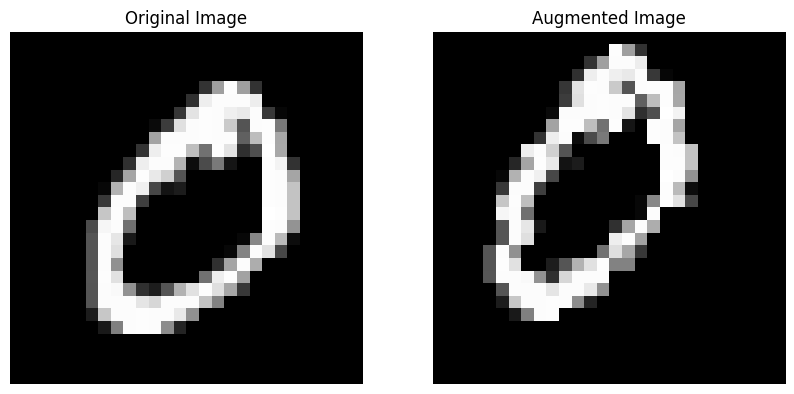

In [317]:
import matplotlib.pyplot as plt

def visualize_augmentation(dataset, index):
    original_image = dataset.images[index].cpu().numpy().reshape(28, 28)
    augmented_image, _ = dataset[index]
    augmented_image = augmented_image.cpu().numpy().reshape(28, 28)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(augmented_image, cmap='gray')
    axes[1].set_title('Augmented Image')
    axes[1].axis('off')
    
    plt.show()

visualize_augmentation(train_dataset, 1)

In [34]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
  print(f"Training on {'GPU :)' if next(model.parameters()).is_cuda else 'CPU.. :('}\n")
  for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
            
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
        
    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")
        
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in test_loader:
          outputs = model(images)
          loss = criterion(outputs, labels)
          test_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)
        
    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print("=========================================")
    print()

In [35]:
if use_gpu:
  model = Convolutional_neuralnet(train_loader).to(device)
else:
  model = Convolutional_neuralnet(train_loader)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_Rate)


# cpu runtime: 436 seconds
# gpu runtime: 42.6 seconds
train_model(model, train_loader, test_loader, criterion, optimizer, 10)

UnboundLocalError: local variable 'image' referenced before assignment